In [ ]:
import json
import os
import requests
import warnings
from urllib.request import urlretrieve
import scanpy as sc
import anndata
import pandas as pd
import anndata as ad
import re

In [118]:
KPMP_SN_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/kpmp-sn-raw-rnaseq.h5ad')
HuBMAP_LK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/LK_raw_updated_2025_june.h5ad')
HuBMAP_RK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/RK_raw_updated_2025_june.h5ad')

In [122]:
HuBMAP_RK_raw.var.index = HuBMAP_RK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))
HuBMAP_LK_raw.var.index = HuBMAP_LK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))

In [124]:
KPMP_SN_raw.var_names

Index(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000148584',
       'ENSG00000175899', 'ENSG00000245105', 'ENSG00000166535',
       'ENSG00000256661', 'ENSG00000256904', 'ENSG00000184389',
       'ENSG00000128274',
       ...
       'ENSG00000086827', 'ENSG00000174442', 'ENSG00000122952',
       'ENSG00000198205', 'ENSG00000198455', 'ENSG00000070476',
       'ENSG00000203995', 'ENSG00000162378', 'ENSG00000159840',
       'ENSG00000074755'],
      dtype='object', name='index', length=36368)

In [103]:
KPMP_SN_raw.var_names=KPMP_SN_raw.var['feature_name']
HuBMAP_LK_raw.var_names=HuBMAP_LK_raw.var['hugo_symbol']
HuBMAP_RK_raw.var_names=HuBMAP_RK_raw.var['hugo_symbol']

/home/wruopeng/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/home/wruopeng/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [104]:
df = pd.read_csv("outer-cortex-datasets.csv")

# Extract IDs only from HuBMAP URLs
ids = []
for url in df["dataset"].astype(str):
    if "hubmapconsortium" in url:        # keep only HuBMAP
        entity_id = url.strip().split("/")[-1]
        ids.append(entity_id)

In [125]:
ids = (
    df.loc[df["dataset"].astype(str).str.contains("hubmapconsortium", na=False), "dataset"]
      .astype(str)
      .str.strip()
      .str.split("/")
      .str[-1]
      .tolist()
)

# subset: keep LK cells whose obs['dataset'] is in ids
adata_cortex_LK = HuBMAP_LK_raw[HuBMAP_LK_raw.obs["dataset"].isin(ids)].copy()
adata_cortex_RK = HuBMAP_RK_raw[HuBMAP_RK_raw.obs["dataset"].isin(ids)].copy()

In [106]:
KPMP_SN_raw

AnnData object with n_obs × n_vars = 304989 × 36368
    obs: 'library_id', 'nCount_RNA', 'nFeature_RNA', 'percent.er', 'percent.mt', 'subclass.l2', 'subclass.l1', 'class', 'experiment_id', 'suspension_type', 'assay_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'specimen', 'disease_category', 'disease_ontology_term_id', 'eGFR', 'diabetes_history', 'hypertension', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'region', 'percent.cortex', 'percent.medulla', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'Age_binned', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

In [107]:
adata_cortex_LK
adata_cortex_RK

AnnData object with n_obs × n_vars = 1272174 × 60286
    obs: 'uuid', 'hubmap_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'predicted_CLID', 'predicted_label', 'cl_match_type', 'prediction_score'
    var: 'hugo_symbol'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [138]:
Hubmap_shared = {
    "cell_id": "cell_id", 
    "predicted_CLID": "cl_id",
    "predicted_label": "cell_type",
    "n_genes": "gene_count",
    "age": "age",
    "sex": "sex",
    "race": "race",
    "hubmap_id":"library_id"
}
HubMap_var_shared = {
    "hugo_symbol": "feature_name"
}

In [139]:
adata_cortex_LK.obs['as_id'] = "UBERON:0002113"
adata_cortex_LK.obs['disease'] = "normal"
adata_cortex_LK.obs['consortium'] = 'HuBMAP'
adata_cortex_RK.obs['as_id'] = "UBERON:0002113"
adata_cortex_RK.obs['disease'] = "normal"
adata_cortex_RK.obs['consortium'] = 'HuBMAP'

adata_cortex_LK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_LK.var.rename(columns=HubMap_var_shared, inplace=True)
    
adata_cortex_RK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_RK.var.rename(columns=HubMap_var_shared, inplace=True)

In [140]:
kpmp_subset=KPMP_SN_raw[KPMP_SN_raw.obs['tissue']== 'cortex of kidney']
kpmp_subset=kpmp_subset[kpmp_subset.obs['disease']== 'normal']

In [129]:
adata_cortex_LK.var_names

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000288635', 'ENSG00000288636', 'ENSG00000288637',
       'ENSG00000288638', 'ENSG00000288639', 'ENSG00000288640',
       'ENSG00000288642', 'ENSG00000288643', 'ENSG00000288644',
       'ENSG00000288645'],
      dtype='object', length=60286)

In [144]:

kpmp_subset

View of AnnData object with n_obs × n_vars = 70118 × 36368
    obs: 'library_id', 'nCount_RNA', 'nFeature_RNA', 'percent.er', 'percent.mt', 'subclass.l2', 'subclass.l1', 'class', 'experiment_id', 'suspension_type', 'assay_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'specimen', 'disease_category', 'disease_ontology_term_id', 'eGFR', 'diabetes_history', 'hypertension', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'region', 'percent.cortex', 'percent.medulla', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'Age_binned', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

In [146]:
adata_cortex_LK

AnnData object with n_obs × n_vars = 328483 × 60286
    obs: 'uuid', 'library_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'cl_id', 'cell_type', 'cl_match_type', 'prediction_score', 'as_id', 'disease', 'consortium'
    var: 'feature_name'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [147]:
adata_cortex_RK

AnnData object with n_obs × n_vars = 1272174 × 60286
    obs: 'uuid', 'library_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'cl_id', 'cell_type', 'cl_match_type', 'prediction_score', 'as_id', 'disease', 'consortium'
    var: 'feature_name'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [152]:
common = kpmp_subset.var_names.intersection(adata_cortex_LK.var_names).intersection(adata_cortex_RK.var_names)

def get_sym(a):
    if "feature_name" in a.var: return a.var.loc[common, "feature_name"].astype("string")
    if "gene_name" in a.var:    return a.var.loc[common, "gene_name"].astype("string")
    return pd.Series(pd.NA, index=common, dtype="string")

sym = get_sym(kpmp_subset).fillna(get_sym(adata_cortex_LK)).fillna(get_sym(adata_cortex_RK))
# fallback to var_names if still NA
sym = sym.fillna(pd.Series(common.astype(str), index=common, dtype="string"))

# attach the unified gene_symbol to each dataset BEFORE concat
kpmp2 = kpmp_subset[:, common].copy()
lk2   = adata_cortex_LK[:, common].copy()
rk2   = adata_cortex_RK[:, common].copy()

for a in (kpmp2, lk2, rk2):
    a.var["gene_symbol"] = sym.loc[a.var_names].astype(str)

adata_combined = ad.concat(
    [kpmp2, lk2, rk2],
    join="inner",
    label="batch_combine",
    keys=["KPMP","HuBMAP_LK","HuBMAP_RK"],
    merge="same",   # now it's identical across all three, so "same" is safe
)

In [153]:
adata_combined

AnnData object with n_obs × n_vars = 1670775 × 36297
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'batch_combine'
    var: 'gene_symbol'

Index([], dtype='object')

In [154]:
sc.pp.filter_cells(adata_combined, min_genes=200)
sc.pp.filter_genes(adata_combined, min_cells=3)

In [155]:
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
sc.pp.scale(adata_combined, max_value=10)

In [156]:
adata_combined

AnnData object with n_obs × n_vars = 372163 × 35306
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'batch_combine', 'n_genes'
    var: 'gene_symbol', 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [158]:
sc.pp.highly_variable_genes(
    adata_combined,
    n_top_genes=3000,
    batch_key='library_id'
)

# # Subset to HVGs
adata_combined = adata_combined[:, adata_combined.var['highly_variable']].copy()

/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessin

2026-01-13 18:05:33,881 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-01-13 18:06:18,970 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-01-13 18:06:22,757 - harmonypy - INFO - Iteration 1 of 500
2026-01-13 18:12:01,121 - harmonypy - INFO - Iteration 2 of 500
2026-01-13 18:17:55,590 - harmonypy - INFO - Converged after 2 iterations


KeyError: 'Could not find key batch in .var_names or .obs.columns.'

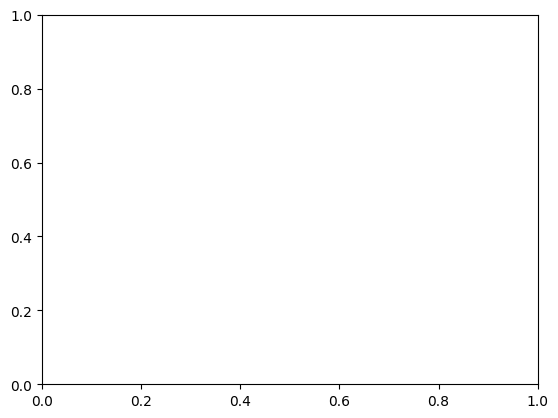

In [159]:
sc.pp.pca(adata_combined, n_comps=50)
sc.external.pp.harmony_integrate(adata_combined, key=['batch_combine','library_id'],
    max_iter_harmony=500)
sc.pp.neighbors(adata_combined, n_neighbors=50, n_pcs=50, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined, min_dist=0.3)
sc.pl.umap(
    adata_combined,
    color=['batch_combine'],
    save="scale_3000_batch_umap_cmu_data.png"   # file will be saved as figures/umap_batch_umap.png
)

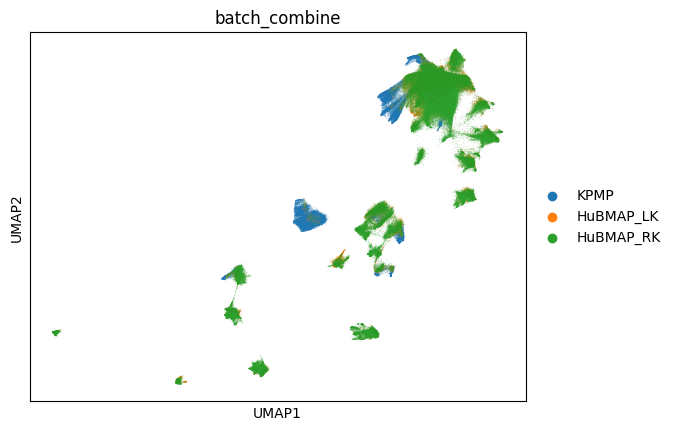

In [160]:
sc.pl.umap(
    adata_combined,
    color=['batch_combine'],
    save="scale_3000_batch_umap_cmu_data.png"   # file will be saved as figures/umap_batch_umap.png
)

In [ ]:
out_path = "/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/KPMP_HuBMAP_project_update/2025_11_15/"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

adata_combined.write(f'{out_path}hvg_3000_kidney_cortex_adata_combined.h5ad')

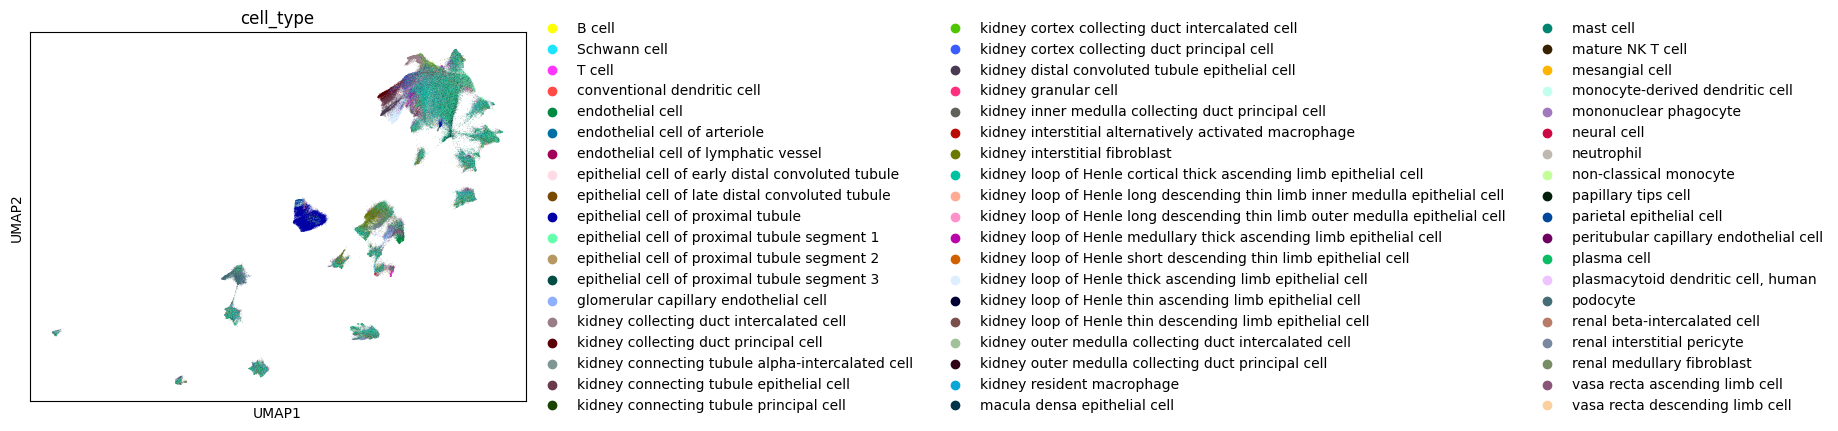

In [161]:
sc.pl.umap(
    adata_combined,
    color=['cell_type']
)

/tmp/ipykernel_17587/2287135618.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_combined_KPMP.obs["all_blue"] = "KPMP"


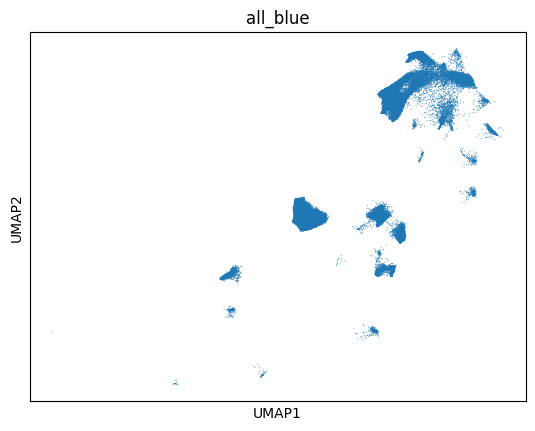

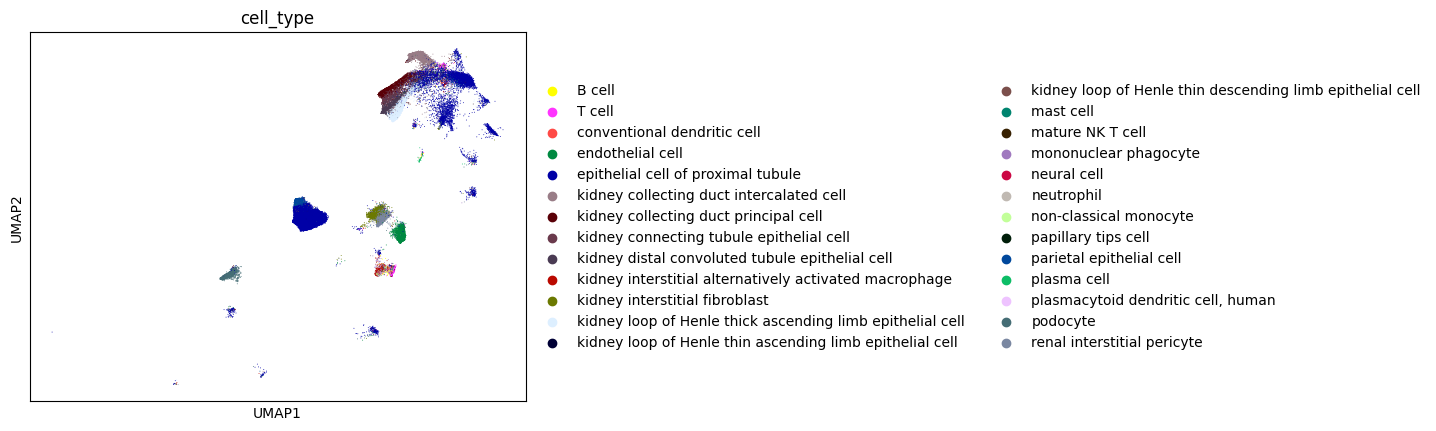

In [165]:
adata_combined_KPMP=adata_combined[adata_combined.obs['batch_combine']=='KPMP']
adata_combined_KPMP.obs["all_blue"] = "KPMP" 
sc.pl.umap(
    adata_combined_KPMP,
    color="all_blue",
    palette=["#1f77b4"],   # blue
    legend_loc=None        #
)
sc.pl.umap(
    adata_combined_KPMP,
    color=['cell_type']
)

/tmp/ipykernel_17587/2267400158.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_combined_HuBMAP_RK.obs["all_blue"] = "HuBMAP_RK"


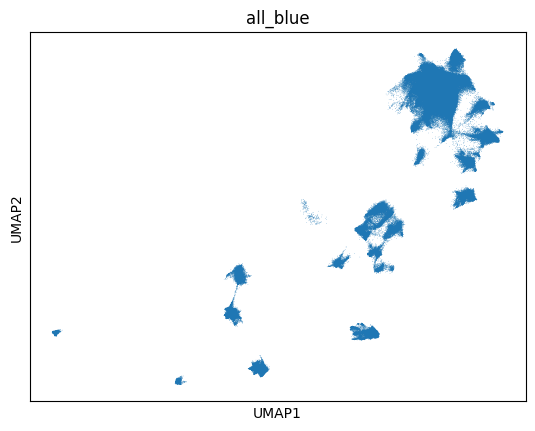

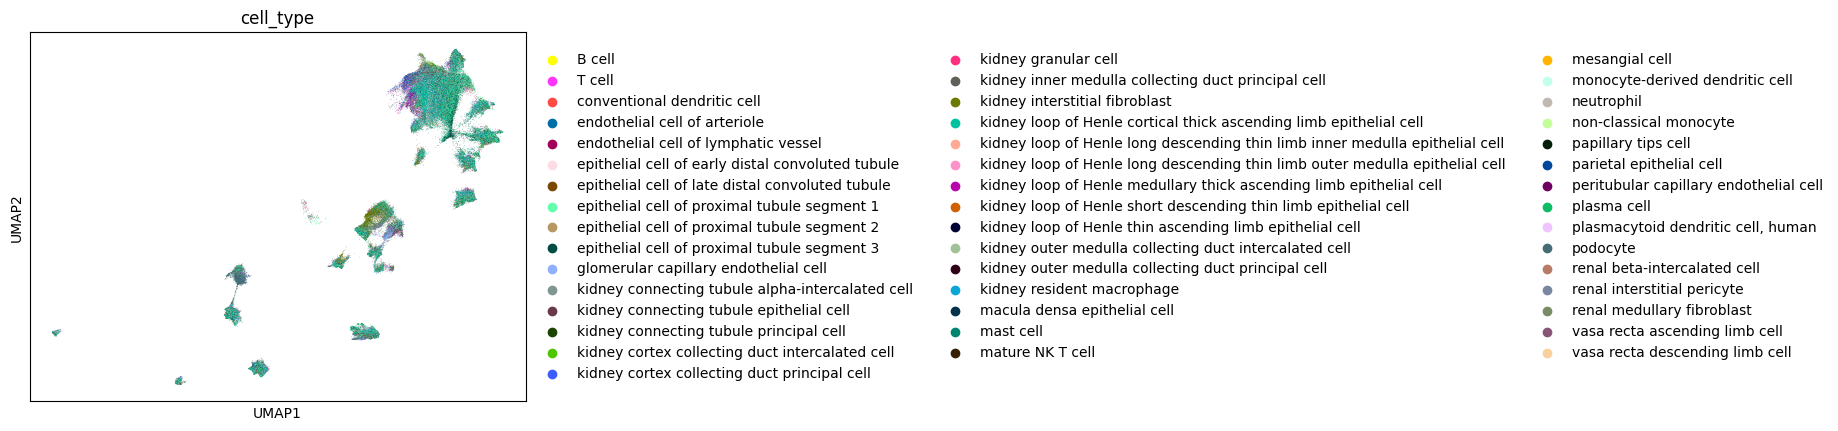

In [166]:
adata_combined_HuBMAP_RK=adata_combined[adata_combined.obs['batch_combine']=='HuBMAP_RK']
adata_combined_HuBMAP_RK.obs["all_blue"] = "HuBMAP_RK" 
sc.pl.umap(
    adata_combined_HuBMAP_RK,
    color="all_blue",
    palette=["#1f77b4"],   # blue
    legend_loc=None        #
)
sc.pl.umap(
    adata_combined_HuBMAP_RK,
    color=['cell_type']
)

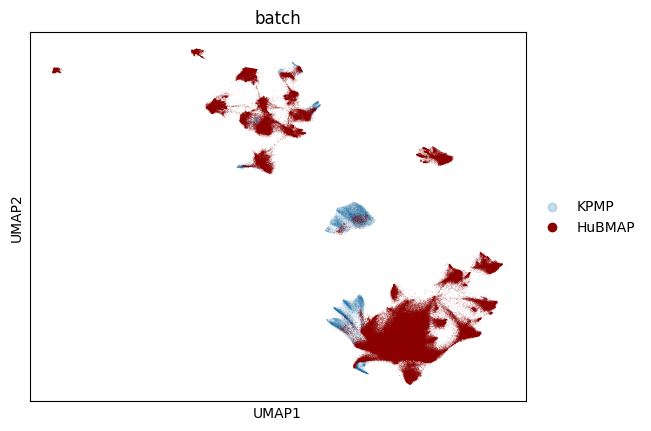

In [25]:
sc.pl.umap(
    adata_combined,
    color=['batch']
)

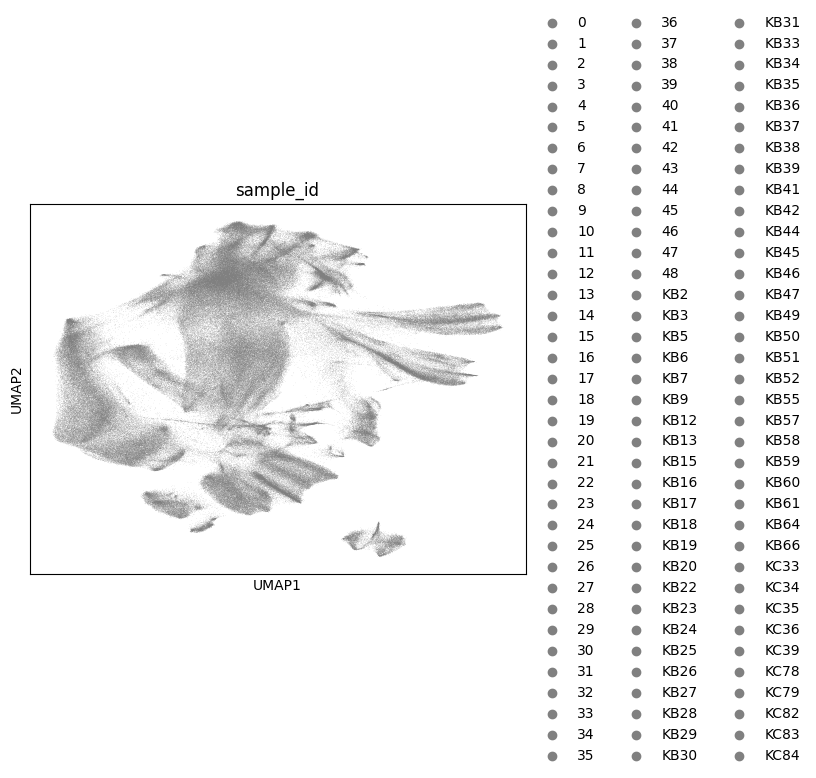

In [16]:
sc.pl.umap(
    adata_combined,
    color=['sample_id'],
    save="scale_no_3000_batch_umap.png"   # file will be saved as figures/umap_batch_umap.png
)

In [17]:
adata_combined_kpmp=adata_combined[adata_combined.obs['batch']=='KPMP']

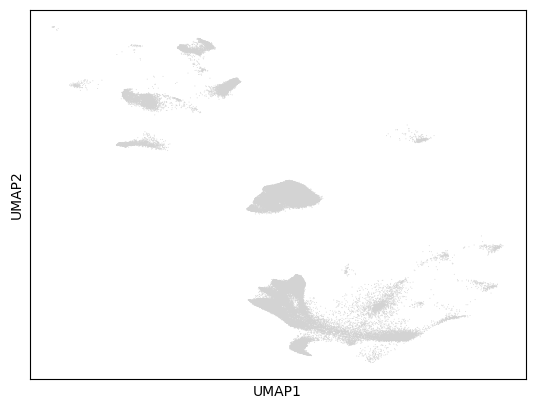

In [18]:
adata_combined_HuBMAP.obs["all_red"] = "KPMP" 
sc.pl.umap(
    adata_combined_HuBMAP,
    color="all_blue",
    palette=["#1f77b4"],   # blue
    legend_loc=None        #
)

/tmp/ipykernel_17587/2335300120.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_combined_HuBMAP.obs["all_blue"] = "HuBMAP"


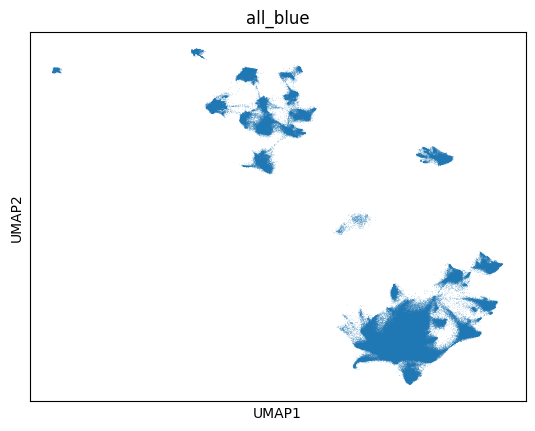

In [23]:
adata_combined_HuBMAP=adata_combined[adata_combined.obs['batch']=='HuBMAP']
adata_combined_HuBMAP.obs["all_blue"] = "HuBMAP" 
sc.pl.umap(
    adata_combined_HuBMAP,
    color="all_blue",
    palette=["#1f77b4"],   # blue
    legend_loc=None        #
)

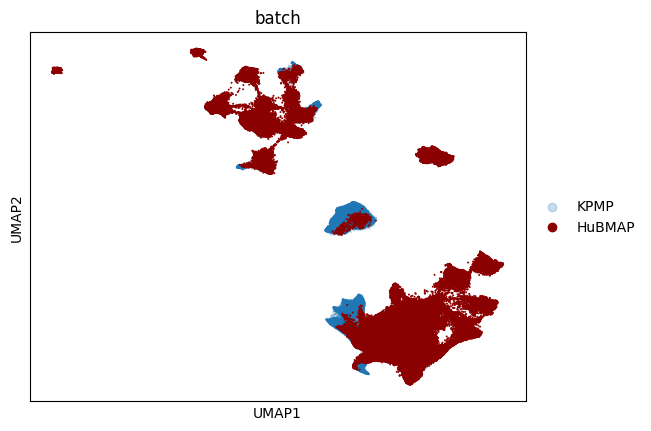

In [24]:
adata_combined.obs["batch"] = adata_combined.obs["batch"].astype("category")


adata_combined.obs["batch"] = adata_combined.obs["batch"].cat.reorder_categories(
    ["KPMP", "HuBMAP"], ordered=True
)

palette = {
    "KPMP": (0.12, 0.47, 0.71, 0.25),  # transparent blue (RGBA)
    "HuBMAP": "#8B0000",               # deep red (darkred)
}

sc.pl.umap(
    adata_combined,
    color="batch",
    palette=palette,
    size=8,          # tweak if needed
    alpha=None       # keep per-group alpha from RGBA (don’t override globally)
)